## Homework 5 - Explore Wikipedia's hyperlinks network

### Authors
* Michelangelo Saveriano
* Flavia Penta
* Timea Aszalos
* Nicola Calabrese

## Useful libraries

In [47]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
import numpy as np
from collections import deque

For this homework we decide to implement from zero our class **HMGraph** instead of using the Python library networkx, in order to understand better the property and algorithm and the of ***Graph Teory***.


# HWGraph class

In [183]:
class HWGraph:
    def __init__(self, edge_df, category_df=None, names_df=None):
        nodes = pd.concat([edge_df.Source, edge_df.Target]).unique()

        # Find the neighbour for each node
        self.neighbors = dict()
        for node in nodes:
            self.neighbors[node] = []
        for s, t in edge_df.values:
            self.neighbors[s].append(t)

        # Create the edges dataframe
        self.edges = edge_df

        # Create the nodes dataframe
        self.nodes = pd.DataFrame.from_dict(data={'Node': self.neighbors.keys(),
                                                  'Neighbour': self.neighbors.values()}).set_index('Node')
        self.nodes = self.nodes.join(self.in_degree(False, False)).join(self.out_degree(False, False),
                                                                        lsuffix='In', rsuffix='Out').fillna(0)

        if category_df is not None:
            self.set_category(category_df)

        if names_df is not None:
            self.set_names(names_df)

        # Calculate the number of nodes and the number of edges
        self.n_nodes = len(self.nodes)
        self.n_edges = len(self.edges)

    def set_category(self, category_df):
        # Assign the node's category
        self.nodes = self.nodes.join(category_df.Category)

    def set_names(self, names_df):
        # Assign the node's label
        self.nodes = self.nodes.join(names_df.Names)

    def is_directed(self):
        # If the number of sources is different from the number of targets the graph is directed
        n_source, n_target = self.edges.nunique()
        if n_source != n_target:
            return True

        edge_list = self.edges.values.tolist()
        # For each edge (s,t) if the opposite edge (t,s) is not in the graph then the graph is directed
        for s, t in edge_list:
            if [t, s] not in edge_list:
                return True
        # Otherwise the graph is not directed
        return False

    def out_degree(self, average_degree=True, centrality=True):
        if average_degree:
            # If average degree is true the function returns the average out degree in the graph
            return self.edges.groupby('Source').size().sum() / self.n_nodes
        else:
            # Calculates the out degree for each node
            out_degree = self.edges.groupby('Source').count().rename(columns={'Target': 'OutDegree'})
            out_degree.index.rename('Node', inplace=True)

            if centrality:
                # If centrality is true then returns the node's centrality
                # given by the ratio between the degree and the number of nodes
                return out_degree / (self.n_nodes - 1)
            # Otherwise returns the out degree of each node
            return out_degree.OutDegree

    def in_degree(self, average_degree=True, centrality=True):
        if average_degree:
            # If average degree is true the function returns the average in degree in the graph
            return self.edges.groupby('Target').size().sum() / self.n_nodes
        else:
            # Calculates the in degree for each node
            in_degree = self.edges.groupby('Target').count().rename(columns={'Source': 'InDegree'})
            in_degree.index.rename('Node', inplace=True)
            if centrality:
                # If centrality is true then returns the node's centrality
                # given by the ratio between the degree and the number of nodes
                return in_degree / (self.n_nodes - 1)
            # Otherwise returns the in degree of each node
            return in_degree.InDegree

    def density(self):
        # Return the density of the graph
        return self.n_edges / (self.n_nodes * (self.n_nodes - 1))

    def plot_degree_distr(self, plot_in_degree=True, plot_out_degree=True, log=True):
        # Plot In Degree
        if plot_in_degree:
            degrees_in = self.in_degree(False, False).values
            plt.figure(figsize=(16, 9))
            plt.title('In Degree Distribution', size=22)
            plt.ylabel('Prob.', size=18)
            plt.xlabel('In Degree', size=18)
            plt.hist(degrees_in, 100, log=log, density=True)
            plt.show()

        # Plot Out Degree
        if plot_out_degree:
            degrees_out = self.out_degree(False, False).values
            plt.figure(figsize=(16, 9))
            plt.title('Out Degree Distribution', size=22)
            plt.ylabel('Prob.', size=18)
            plt.xlabel('Out Degree', size=18)
            plt.hist(degrees_out, 100, log=log, density=True)
            plt.show()

    def bfs(self, source_node, max_distance=math.inf, return_dataframe=True):
        '''
        Computes the shortest paths from a source node to all the other nodes of the graph.
        We are considering only the nodes that exist in the graph for simplicity.

        :param G: Graph
        :param source_node: An article/node associated to the chosen category, C0
        :return: Dictionary containing target nodes as keys and length of the shortest paths as values
        '''
        if source_node not in self.neighbors:
            print(f'The node {source_node} is not present in the graph!')
            return
        visited = {source_node: 0}
        queue = deque([source_node])
        while len(queue) > 0:
            node = queue.popleft()
            distance = visited[node]

            for adjacent in self.neighbors[node]:
                if adjacent not in visited and distance < max_distance:
                    queue.append(adjacent)
                    visited[adjacent] = distance + 1

        if not return_dataframe:
            return visited

        df = self.nodes.loc[visited.keys()]
        df['Distance'] = visited.values()
        return df[['Names', 'Distance']]

    def find_distance(self, source, targets, test_connectivity=False, inf_dist=True, return_dataframe=True):
        dist = self.bfs(source, return_dataframe=False)

        if test_connectivity and not targets.issubset(dist.keys()):
            print("Not possible!")
            return

        if inf_dist:
            dist = {node: dist[node] if node in dist else math.inf for node in targets}
        else:
            dist = {node: dist[node] for node in targets if node in dist}

        if return_dataframe:
            return pd.DataFrame({'Nodes': dist.keys(), 'Distances': dist.values()}).set_index('Nodes')
        return dist

    def min_clicks(self, C, p):
        # Find the most central article v in the category C
        C_nodes = self.nodes[self.nodes.Category == C]
        v = C_nodes.InDegree.idxmax()
        # Find the distances between the node v and the nodes p
        visited = self.find_distance(v, p, True, inf_dist=False)
        # If visited exists then return the max distance
        if visited is not None:
            return visited.Distances.max()

    def contract(self):
        # Contraction algorithm used by the Karger's algorithm
        edges = self.edges.copy()
        # If exist we remove the self loops
        if (edges.Source == edges.Target).any():
            edges = edges[~(edges.Source == edges.Target)]

        # Calculate the number of nodes
        n_nodes = pd.concat([edges.Source, edges.Target]).nunique()

        # While there are more than 2 nodes in the graph
        while n_nodes > 2:
            # Find the source and the target of a random edge
            s, t = edges.sample().values[0]

            # Removes the edges between s and t, in both directions
            edges = edges[~((edges.Source == s) & (edges.Target == t))]
            edges = edges[~((edges.Source == t) & (edges.Target == s))]

            # Remove node t, moving its edges to s
            edges.loc[edges.Source == t, 'Source'] = s
            edges.loc[edges.Target == t, 'Target'] = s

            # Updates n_nodes
            n_nodes = pd.concat([edges.Source, edges.Target]).nunique()

            # If the number of nodes is greater than the number of edges then
            # the graph is not connected
            if n_nodes > len(edges):
                # If the graph is not connected then returns 0
                return 0

        # Return the remaining edges
        return len(edges)

    def min_link_to_disconnect(self, C1, C2):
        # We use the Karger's algorithm to find the min-cut
        # Find the nodes belonging to category C1 or category C2
        nodes = self.nodes[(self.nodes.Category == C1) | (self.nodes.Category == C2)].index
        # Find the edges between those nodes
        edges = self.edges[self.edges.Source.isin(nodes) & self.edges.Target.isin(nodes)]
        # Then we create the induced subgraph
        G = HWGraph(edges)

        # If the graph is empty returns 0
        if G.n_nodes == 0:
            return 0

        min_links = math.inf
        # Perform N^2*log(N) times the Karger's algorithm and return best results
        for i in range(int((G.n_nodes ** 2) * math.log(G.n_nodes))):
            res = G.contract()
            if res < min_links:
                min_links = res
                if min_links == 0:
                    return 0

        return min_links

    def build_category_articles_dictionary(self):
        df_article_category = self.nodes.Category.reset_index()
        categories = df_article_category.Category.unique().tolist()
        
        articles = []
        for category in categories:
            articles.append(df_article_category[df_article_category.Category == category].Node.values.tolist())
            
        return dict(zip(categories, articles))

    def distances_from_category(self, C, consider_disconnected_nodes=True):
        # Build the category-articles dictionary
        category_articles_dict = self.build_category_articles_dictionary()
        # Check if the category C exists
        if C not in category_articles_dict:
            print(f"The category {C} doesn't exist.")
            return
        # Create the categories list wth all the category but C
        categories = list(category_articles_dict.keys())
        categories.remove(C)
        # Create the nodes list with all the nodes that doesn't belong to C
        nodes = sum([category_articles_dict[i] for i in categories], [])
        # Create the distances dataframe
        distances = pd.DataFrame(columns=['C0', 'Ci', 'Dist'])

        # Compute path lengths from all the nodes in C to all other nodes in the graph
        shortest_path_lengths = {}
        for source_node in tqdm(category_articles_dict[C]):
            for target_node, path_length in self.find_distance(source_node, nodes,
                                                               inf_dist=consider_disconnected_nodes,
                                                               return_dataframe=False).items():
                if target_node not in shortest_path_lengths:
                    shortest_path_lengths[target_node] = []
                shortest_path_lengths[target_node].append(path_length)
        
        # Cumpute the median distance and append it to the distances dataframe
        for category_name, category_nodes in tqdm(category_articles_dict.items()):
            # Jump to next iteration if category is equal to C
            if category_name == C:
                continue
            # List of shortest path of a category
            category_paths_lengths = [
                path_length
                for category_node in category_nodes
                for path_length in shortest_path_lengths.get(category_node,[])
            ]
            # If category_paths_lengths is not empty
            if category_paths_lengths:
                distances = distances.append({'C0':C, 'Ci':category_name, 
                                              'Dist':np.median(category_paths_lengths)},
                                             ignore_index=True)
        # Return the distances sorted by the distance value in descending order
        return distances.sort_values('Dist', ascending=False)

    def category_rank(self):
        # Create the network of categories
        edges = self.edges.join(self.nodes.Category, on='Source').join(self.nodes.Category, on='Target',
                                                                       lsuffix='Source', rsuffix='Target')
        categories_edges = edges.groupby(['CategorySource', 'CategoryTarget']).size()
        categories = pd.concat([edges.CategorySource, edges.CategoryTarget]).unique()
        n_categories = categories.size
        # Adjacency matrix
        M = np.zeros((n_categories, n_categories))
        for i in range(n_categories):
            for j in range(n_categories):
                if (categories[i], categories[j]) in categories_edges.index:
                    M[i, j] = categories_edges.loc[categories[i], categories[j]]
        # Normalize the matrix along rows
        sums = M.sum(axis=1)
        if (sums == 0).any():
            M[sums == 0] += 1
        M /= sums.reshape(n_categories, 1)
        # Calculate the pagerank
        v = pagerank(M).flatten()
        # Then returns a dataframe containing the results in descending order
        return pd.DataFrame({'Category': categories, 'PageRank': v}).sort_values('PageRank', ascending=False)

In [138]:
distances = distances.append({'C0':'a', 'Ci':'b', 'Dist':'c'},
                                             ignore_index=True)

In [139]:
distances

,C0,Ci,Dist
0,a,b,c


# Load Datasets
## Read file with edges

In [33]:
df_edges = pd.read_csv('./data/wikigraph_reduced.csv',sep='\t',index_col=0,names=['Source','Target'],header=0)
df_edges.reset_index(drop=True,inplace=True)

## Read file with Categories

Here we load the file with category ,then we find the number of Articles belonging to each category and finally remove the categories with less of 5000 and more than 30000 articles.

In [34]:
df_category = pd.read_csv("./data/wiki-topcats-categories.txt",sep=';',names=['Category','Articles'],header=0)
df_category['Category'] = df_category.Category.apply(lambda x: x.split(':')[1])
df_category['Articles'] = df_category.Articles.apply(lambda x : list(map(int,x.split())))
# Find the number of articles for each category
df_category['lens'] = [len(x) for x in df_category['Articles']]
# Removes the categories whose number of articles in less than 5000 and more than 30000.
df_category = df_category.loc[(df_category['lens']>5000) & (df_category['lens']<30000)]

In [6]:
df_category

,Category,Articles,lens
867,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295...",9237
868,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280...",9467
875,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269...",6959
899,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268...",8270
948,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269...",6668
2790,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,...",6154
4159,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,...",6580
5618,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306...",6546
6066,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233...",5913
6794,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,...",7851


### Now we verify that our articles belong to these filtered categories

In [8]:
categories_articles = set(df_category.Articles.sum())
our_articles = set(pd.concat([df_edges.Source, df_edges.Target]).unique())

In [11]:
if our_articles.issubset(categories_articles):
    print('Our articles belong to the filtered categories.')
else:
    print("Our articles don't belong to the filtered categories.")

Our articles belong to the filtered categories.


### Select a random category for each article
If one article belongs to multiple categories we assing it at random to one of these.

In [36]:
df_article = pd.concat([pd.DataFrame(data = {'Articles': df_category.loc[i].Articles, 
                                             'Category': df_category.loc[i].Category}) for i in df_category.index], 
                       ignore_index=True)
rand_article = df_article.groupby('Articles').sample(random_state=1)
df_article_category = pd.DataFrame(data={'Articles': rand_article.Articles, 'Category': rand_article.Category})
df_article_category.set_index('Articles', inplace=True)

In [8]:
df_article_category

,Category
Articles,
55,English-language_films
77,Harvard_University_alumni
79,Major_League_Baseball_pitchers
95,Debut_albums
98,Year_of_death_missing
...,...
1790843,Harvard_University_alumni
1791481,English-language_films
1791482,Association_football_midfielders


In [35]:
# with open("./data/article-category.csv", "w") as article_category_file:
#     article_category_file.write(df_article_category.reset_index().to_csv(index=False).replace('\r', ''))
df_article_category = pd.read_csv("./data/article-category.csv")
df_article_category.set_index('Articles', inplace=True)

## Read file with page names

In [36]:
df_names = pd.read_csv("./data/wiki-topcats-page-names.txt", header=None, names=['Names'])
df_names['Names'] = df_names.Names.apply(lambda x: x.split(' ', 1)[1])

In [14]:
df_names

,Names
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem
...,...
1791484,Noadiah Russell (Yale founder)
1791485,Cornus officinalis
1791486,Peter Grummitt
1791487,Baron Estcourt


# Create the Graph

Our object G has two attibutes: ***nodes*** and ***edges***.
In particular the attribute *nodes* returns a dataframe that summarizes a lot of properties of each nodes,such as:
* **Neighbour** -> the list of nodes directly linked to the source (only outgoing edges)
* **In-Degree** -> number of Incoming edges where Incoming edges of a vertex are directed edges that the vertex is the destination.
* **Out-Degree** -> number of Outgoing edges where Outgoing edges of a vertex are directed edges that the vertex is the origin.
* **Category** and **Names** label) of the nodes.

In [98]:
G = HWGraph(df_edges, category_df=df_article_category, names_df=df_names)

In [51]:
G.nodes

,Neighbour,InDegree,OutDegree,Category,Names
Node,,,,,
95,[1185516],0.0,1.0,Debut_albums,This Way (Hana Pestle album)
108,"[1059989, 1062426, 1161925]",0.0,3.0,Debut_albums,Born Innocent (Redd Kross album)
134,"[541222, 1061485, 1163610, 1163783]",5.0,4.0,English-language_films,San Quentin (1937 film)
153,"[744272, 1064807, 1065282, 1085943, 1125916, 1...",5.0,9.0,English-language_films,35 and Ticking
167,"[645690, 804311]",2.0,2.0,Place_of_birth_missing_(living_people),Donna Dubinsky
...,...,...,...,...,...
1789654,[],1.0,0.0,English-language_films,Allan Quatermain and the Temple of Skulls
1356290,[],1.0,0.0,English-language_films,The Cottage (film)
1053684,[],1.0,0.0,American_television_actors,Eric Lutes


# Answers

## Question 1

## Is the graph directed?

In [40]:
if G.is_directed():
    print('The graph is directed')
else:
    print('The graph is not directed')

The graph is directed


Yes! We are working on a directed graph $G=(V,E)$, where our nodes $V$ (articles) are connected together by edges $E$ (hyperlinks) directed from one vertex to another. 

We verify this property looking at the number of sources and targets ,because in an undirected graph each vertex is both sorce than target , and since we assume that all edges in the graphs have weight equal to 1, we should find each edges in both directions ,but this isn't the case. 

## How many articles are we considering?¶

Since each node corresponds to an article, we can count the number of articles just counting the number of nodes of our Graph $G$:

In [41]:
print(f'We are considering {G.n_nodes} articles.')

We are considering 98343 articles.


## How many hyperlinks between pages exist?
Since each edge corresponds to an hyperlink between 2 articles, we can count the number of hyperlinks just counting the number of edges of our Graph $G$ 

In [42]:
print(f'There are {G.n_edges} hyperlink between pages.')

There are 483094 hyperlink between pages.


 ## Average number of links in an arbitrary page and Density of our Graph

The average degree of our directed graph is: $(k^{in})=(k^{out})=\frac{1}{N} \sum_{i=1}^{N}k_{i}^{in}=\frac{1}{N} \sum_{i=1}^{N}k_{i}^{out}=\frac{totalnumberofhyperlinks}{totalnumberofarticles} $

The density of the graph $G$ measures how many hyperlinks are in set $E$ compared to the maximum possible number of hyperlinks between articles in set $V$

The density of our directed graph is: $D= \frac{|E|}{2\binom{|V|}{2}} = \frac{|E|}{|V|(|V|-1)} $

In [43]:
print(f'The average number of links in an arbitrary page is {G.out_degree()}')
print(f'Graph density: {G.density()}')

The average number of links in an arbitrary page is 4.912337431235573
Graph density: 4.9951571365597335e-05


 ## Check if our graph is Dense or Sparse
 
To see if our graph is sparse or dense, we consider that the density of a sparse graph is in lower range of the density’s codomain $(0\leqslant density < \frac {1} {2})$; the density of a dense graph is in the higher range of its codomain $ ( \frac {1} {2} < density \leqslant  1) $, so:

> **The graph is sparse  !!**

It means that our graph the number of edges is NOT close to the maximal number of edges, in fact the total number of edges of a directed graph is:
> $ E_{max} = V*(V-1)$

In our case the maximum number of edges is 9671247306, but we've only 483094 edges, far from the maximum.

## Nodes' degree distribution

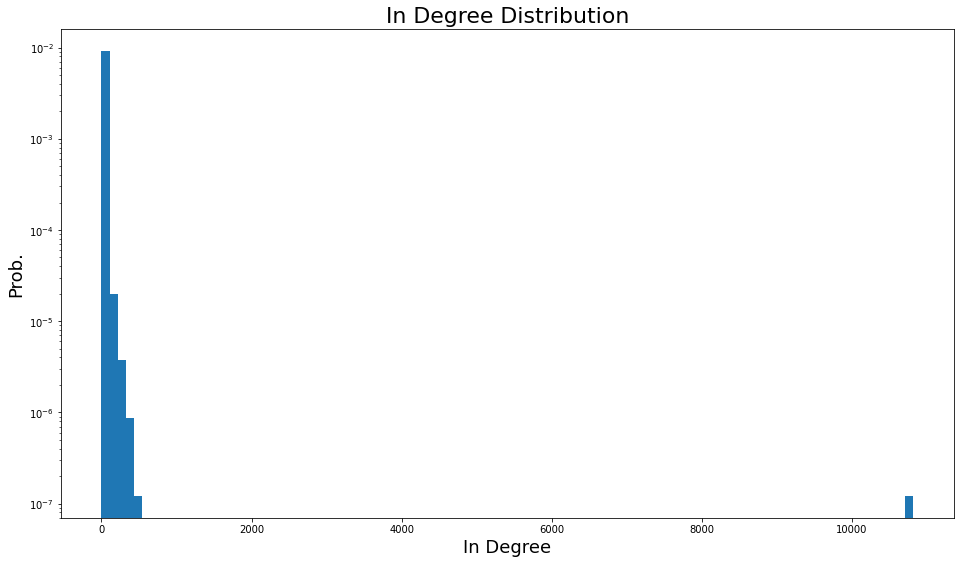

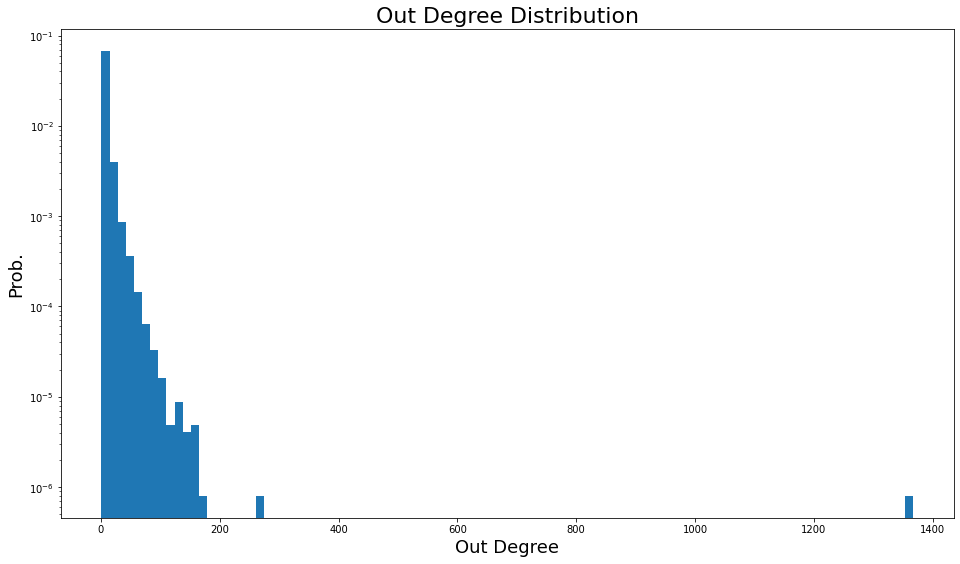

In [44]:
G.plot_degree_distr()

## Question 2

## Breadth-First-Search (BFS) within distance d
Given a page **v** and the number of clicks **d** we have to return the set of all pages that a user can reach within d clicks. This problem is a simple Breadth-First-Search where we stop the algorithm when we find all the nodes ad distance d from the origin.

In [186]:
G.bfs(95) # spiegare meglio che succede

,Names,Distance
Node,,
95,This Way (Hana Pestle album),0
1185516,Marty O'Brien,1
150451,22nd Century Lifestyle,2
1062563,Lindsay Lohan,2
1178930,Marilyn Manson,2
...,...,...
1319244,Janez Jernej Bosio,20
1319269,Gabriel Eder,21
1319255,Janez Dolnitscher,22


In [187]:
G.bfs(235101) # provare con un nodo che non esiste nel grafo

The node 235101 is not present in the graph!


In [188]:
G.bfs(235100) # provare con un nodo isolato

,Names,Distance
Node,,
235100,James Pierpont (Yale founder),0


Starting from the node **95** we can reach 64013 different nodes,here we return their label and their distance from the orign.

## Question 3
Given in input:
* A category C
* A set of pages in C, p = {p1, ..., pn}

returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

As metrics of centrality, we adopted the Degree centrality for directed networks, with:

$centrality_{indegree}^{v}=\frac{deg_{indegree}^{v}}{|N|-1}$

where:

$centrality_{indegree}^{v}$ is the centrality-score of a node $v$
$deg_{indegree}^{v}$ is the IN-degree of node $v$
$|N|$ is the number of nodes of the graph $G$

Due to the problem is computational expensive we run it first for a small random number of pages than fore more pages,all of them are taken from a category chosen at random from all category we have.

First example:

In [87]:
C = G.nodes.Category.sample().iloc[0]
max_pages = 3
n_pages = np.random.randint(1, max_pages)
p = set(G.nodes[G.nodes.Category == C].sample(n_pages, replace=True).index.tolist())
min_click = G.min_clicks(C, p)
if min_click is not None:
    print(f"To reach the pages {p}, belonging to the category {C}, starting from the category's most central article it requires at least {min_click} clicks.")
else:
    print(f"It's not possible to reach all the pages {p}, belonging to the category {C}, starting from the category's most central article.")

To reach the pages {473283, 830189}, belonging to the category English-language_films, starting from the category's most central article it requires at least 4 clicks.


Second example

In [89]:
C = G.nodes.Category.sample().iloc[0]
max_pages = 20
n_pages = np.random.randint(5, max_pages)
p = set(G.nodes[G.nodes.Category == C].sample(n_pages, replace=True).index.tolist())
min_click = G.min_clicks(C, p)
if min_click is not None:
    print(f'To reach the pages {p}, belonging to the category {C}, it requires at least {min_click} clicks.')
else:
    print(f"It's not possible to reach all the pages {p}, belonging to the category {C}.")

Not possible!
It's not possible to reach all the pages {358049, 1787012, 1055462, 1057063, 1058377, 1041770, 838058, 1789641, 1429709, 1044975, 1046548, 1047063, 674331}, belonging to the category English-language_films.


## Question 4
Given in input two categories: $C1$ and $C2$, we get the subgraph induced by all the articles in the two categories.
* Let v and u two arbitrary pages in the subgraph return  minimum set of hyperlinks one can remove to disconnect u and v.

The ***induced subgraph*** of a graph is another graph, formed from a subset of the vertices of the graph and all of the edges connecting pairs of vertices in that subset.

In our particular case the subset of nodes is the one made by the articles belonging to the two category $C1$ and $C2$ that we choose at random from all the categories.

Then chosen $v$ and $u$ the minimum number of links that we have to remove to disconnect them is the same of calculating the number of edges of the min cut which divide the graph in two partitions $P1$ and $P2$ such that $ v \in P1$ and $ u \in P2$.


To find the min cut we used the **Karger's Algorithm** which is a randomized algorithm that gives a good approximation for the cardinality of the min-cut.The algorithm follows principally four steps:

1. Choose an edge uniformly at random
2. Contract the edge
3. Repeat steps 1 and 2 until two nodes are left
4. Return the cut defined by the nodes and the esges left

Since the algorithm is a randomized algorithm it may return the wrong answer. So the number of times we have to repeat it in orded to have a $Probability(Fail) \le {1\over n}$ ,where $n$ is the number of edges, is $n^2ln(n)$.

In [90]:
C1, C2 = np.random.choice(G.nodes.Category.unique(), 2)
print(f"The minimum number of hyperlinks we have to remove in order to disconnect two random nodes, belonging to the categories {C1} or {C2}, is {G.min_link_to_disconnect(C1, C2)}")

The minimum number of hyperlinks we have to remove in order to disconnect two random nodes, belonging to the categories English-language_films or American_films, is 0


## Question 5
Given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as

* distance(C0, Ci) = median(ShortestPath(C0, Ci))

where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories.

In [172]:
C = G.nodes.Category.sample().iloc[0]
C

'Black-and-white_films'

In [184]:
G = HWGraph(df_edges, category_df=df_article_category, names_df=df_names)

In [174]:
cat_art = G.build_category_articles_dictionary()
{k: len(cat_art[k]) for k in cat_art.keys()}

{'Debut_albums': 2553,
 'English-language_films': 13427,
 'Place_of_birth_missing_(living_people)': 2552,
 'American_films': 7398,
 'American_television_actors': 6412,
 'American_film_actors': 9145,
 'Harvard_University_alumni': 2964,
 'Asteroids_named_for_people': 2343,
 'Main_Belt_asteroids': 8655,
 'Year_of_death_missing': 1412,
 'Association_football_midfielders': 2788,
 'Black-and-white_films': 5237,
 'Year_of_birth_missing': 1461,
 'Association_football_defenders': 2128,
 'Association_football_forwards': 2494,
 'The_Football_League_players': 3638,
 'English_footballers': 3590,
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies': 6428,
 'Indian_films': 2749,
 'Rivers_of_Romania': 7662,
 'Major_League_Baseball_pitchers': 3307}

In [175]:
G.distances_from_category(C)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:04<00:00,  3.06s/it]


,C0,Ci,Dist
0,Black-and-white_films,Debut_albums,inf
8,Black-and-white_films,Main_Belt_asteroids,inf
17,Black-and-white_films,Indian_films,inf
13,Black-and-white_films,Association_football_forwards,inf
12,Black-and-white_films,Association_football_defenders,inf
11,Black-and-white_films,Year_of_birth_missing,inf
9,Black-and-white_films,Year_of_death_missing,inf
10,Black-and-white_films,Association_football_midfielders,inf
7,Black-and-white_films,Asteroids_named_for_people,inf
6,Black-and-white_films,Harvard_University_alumni,inf


In [185]:
G.distances_from_category(C, consider_disconnected_nodes=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:53<00:00,  2.57s/it]


,C0,Ci,Dist
12,Black-and-white_films,Association_football_defenders,9.0
18,Black-and-white_films,Rivers_of_Romania,9.0
10,Black-and-white_films,Association_football_midfielders,8.0
17,Black-and-white_films,Indian_films,8.0
15,Black-and-white_films,English_footballers,8.0
14,Black-and-white_films,The_Football_League_players,8.0
13,Black-and-white_films,Association_football_forwards,8.0
8,Black-and-white_films,Main_Belt_asteroids,8.0
16,Black-and-white_films,Members_of_the_United_Kingdom_Parliament_for_E...,7.0
19,Black-and-white_films,Major_League_Baseball_pitchers,7.0


## Question 6

## PageRank algorithm


In [176]:
def pagerank(M, num_iterations: int = 100, d: float = 0.85):
    """
    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    
    v = np.random.rand(1, N)
    v = v / np.sum(v)
    M_hat = (d * M + (1 - d) / N)
    for i in range(num_iterations):
        v = v @ M_hat
    return v

In [177]:
G.category_rank()

,Category,PageRank
5,American_film_actors,0.146215
1,English-language_films,0.097378
8,Main_Belt_asteroids,0.083784
4,American_television_actors,0.072805
15,The_Football_League_players,0.066614
16,English_footballers,0.064383
17,Members_of_the_United_Kingdom_Parliament_for_E...,0.061219
3,American_films,0.055908
19,Rivers_of_Romania,0.048081
20,Major_League_Baseball_pitchers,0.046046
